# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [227]:
import warnings
warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'../min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

14.014801740646362


In [228]:
#调用模块
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [229]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [239]:
alpha1=dv1H.add_formula('alpha1_C','RankPct(Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5))',add_data=True, register_funcs={'RankPct':RankPct})

Field [alpha1_C] is overwritten.


In [240]:
alpha1_plot = dv1H.get_ts('alpha1_C', date_type='datetime')
close = dv1H.get_ts('close', date_type='datetime')

In [241]:
def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-150:])
    ax1.plot(alpha.iloc[-150:])
    # plt.savefig('good')
    plt.show()

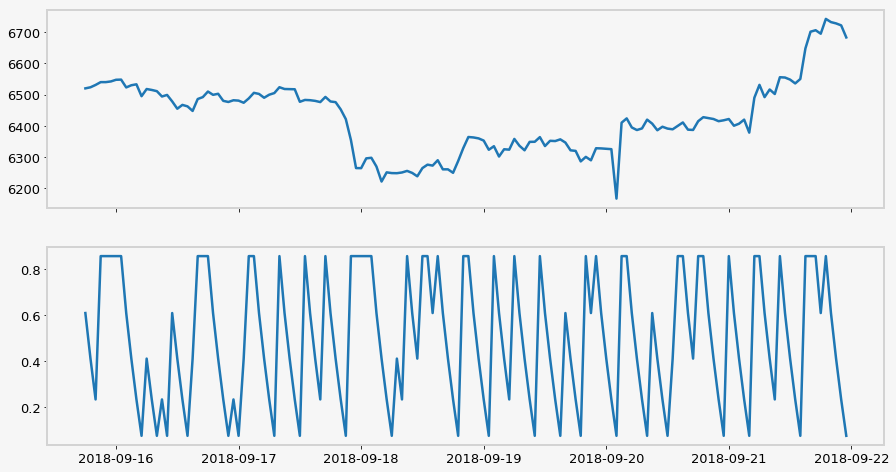

In [242]:
plot_chart(close, alpha1_plot)

动量因子，根据收盘价及短期波动率判断价格短期变化情况，看不出有啥规律，数值较大的股票升值的可能性比较大。后面测试没啥效果，仔细阅读因子原理目测需要多只股票组成股票池才比较靠谱。

In [267]:
# 进场信号
long = dv1H.add_formula("long","If(alpha1_C<0.2,2,0)", add_data=True)
short = dv1H.add_formula("short","If(alpha1_C>=0.8,-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


In [268]:
TimingSignal(tdMa, dv1H, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 15%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 28%


In [269]:
tdMa.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               19.065  -14.901   -0.904
p-value               0.000    0.000    0.366
mean                  0.010   -0.011   -0.001
std                   0.011    0.016    0.018
info_ratio            0.878   -0.702   -0.030
skewness              2.163   -2.870   -1.243
kurtosis              5.825   10.812    7.786
pct5                  0.000   -0.052   -0.029
pct25                 0.002   -0.014   -0.005
pct50                 0.006   -0.005    0.000
pct75                 0.013   -0.002    0.006
pct95                 0.031   -0.000    0.026
occurance           472.000  451.000  923.000
win_ratio               NaN      NaN    0.511
win_mean/loss_mean      NaN      NaN    0.866


In [270]:
tdMa.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss       all
t-stat               28.854  -24.361     0.645
p-value               0.000    0.000     0.519
mean                  0.015   -0.016     0.000
std                   0.016    0.019     0.024
info_ratio            0.935   -0.846     0.015
skewness              1.984   -1.808    -0.392
kurtosis              5.171    2.994     3.061
pct5                  0.001   -0.059    -0.051
pct25                 0.004   -0.021    -0.008
pct50                 0.009   -0.009     0.001
pct75                 0.022   -0.003     0.010
pct95                 0.047   -0.001     0.037
occurance           954.000  830.000  1784.000
win_ratio               NaN      NaN     0.535
win_mean/loss_mean      NaN      NaN     0.911


In [271]:
tdMa.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                         win      loss       all
t-stat                33.874   -28.326     0.143
p-value                0.000     0.000     0.886
mean                   0.013    -0.015     0.000
std                    0.015     0.019     0.022
info_ratio             0.897    -0.792     0.003
skewness               2.126    -2.093    -0.539
kurtosis               6.054     4.700     4.127
pct5                   0.001    -0.056    -0.043
pct25                  0.003    -0.019    -0.006
pct50                  0.008    -0.007     0.001
pct75                  0.019    -0.003     0.008
pct95                  0.042    -0.001     0.032
occurance           1426.000  1281.000  2707.000
win_ratio                NaN       NaN     0.527
win_mean/loss_mean       NaN       NaN     0.906


胜率略高，但是赔钱，说明短期预测方向正确，但是捡小失大，赔钱。

In [272]:
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

In [273]:
cdl3inside = dv1H.add_formula('cdl3inside', "Ta('CDL3INSIDE', 0, open, high, low, close, volume)", add_data=True)

三日K线模式，母子信号+长K线，以三内部上涨为例，K线为阴阳阳，第三天收盘价高于第一天开盘价，第二天K线在第一天K线内部，预示着股价上涨。 

In [274]:
cdl3insideVolume = dv1H.get_ts('cdl3inside', date_type='datetime')

cdl3insideVolume[cdl3insideVolume['BTCUSDT:binance']==100]

In [275]:
cdl3insideVolumeX = cdl3insideVolume[cdl3insideVolume['BTCUSDT:binance']==100].index
cdl3insideVolumeY = data1H.loc[cdl3insideVolumeX].low-100

from matplotlib.pylab import date2num
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

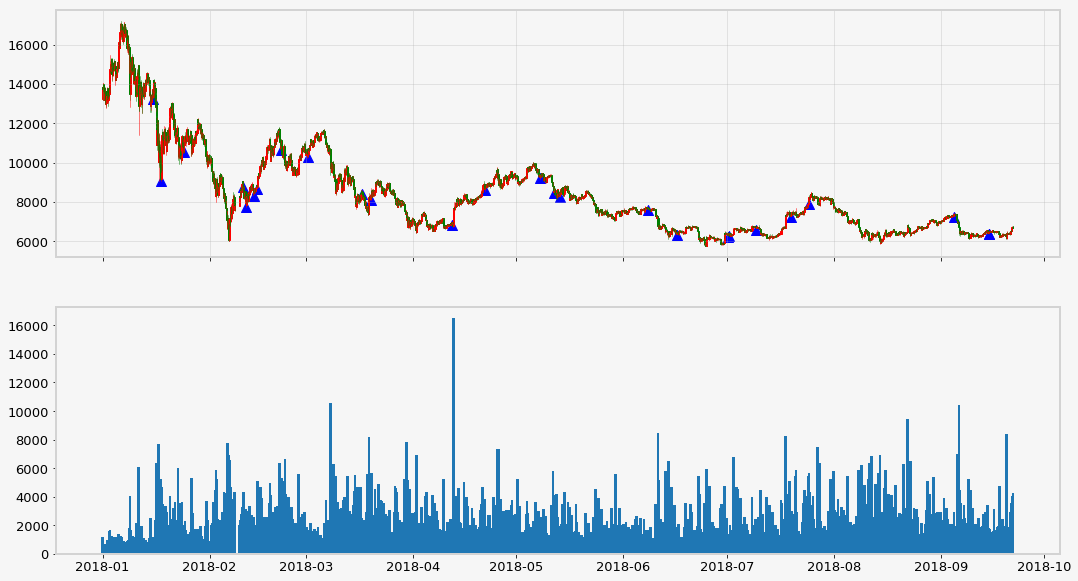

In [276]:
draw_candle(candle, cdl3insideVolumeX, cdl3insideVolumeY)

由图可以看出因子等于100时，之后的价格会上升

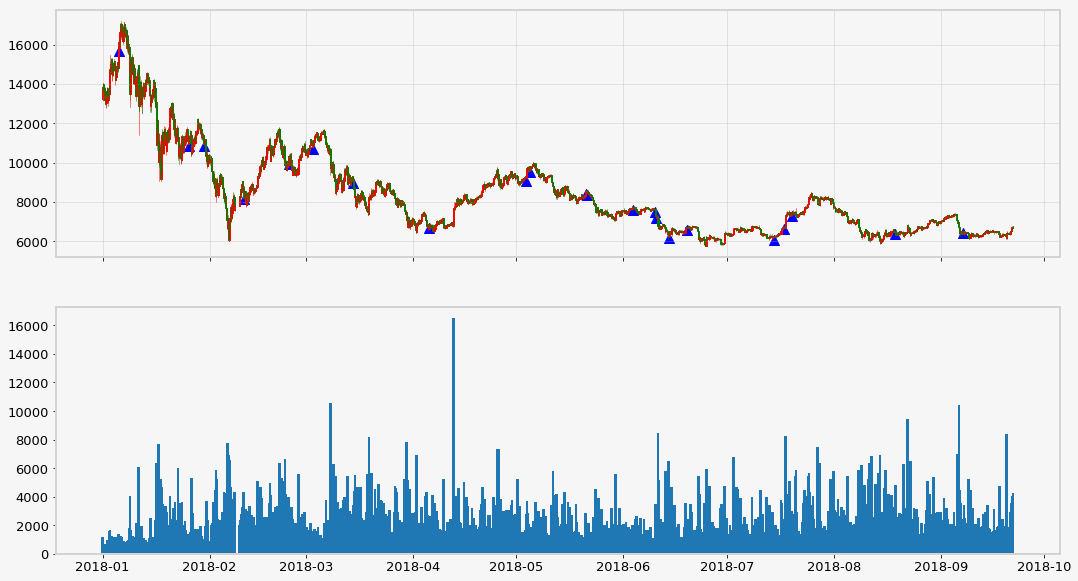

In [277]:
cdl3insideVolumeX = cdl3insideVolume[cdl3insideVolume['BTCUSDT:binance']==-100].index
cdl3insideVolumeY = data1H.loc[cdl3insideVolumeX].low-100
draw_candle(candle, cdl3insideVolumeX, cdl3insideVolumeY)

由图可以看出因子等于-100时，之后的价格会下降

In [284]:
# 进场信号
long = dv1H.add_formula("long","If(cdl3inside==100,2,0)", add_data=True)
short = dv1H.add_formula("short","If(cdl3inside==-100,-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

Field [long] is overwritten.
Field [short] is overwritten.
Field [closeLong] is overwritten.
Field [closeShort] is overwritten.


根据因子构造出场入场信号，100入场，-100出场。

In [289]:
TimingSignal(tdMa, dv1H, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%


In [290]:
tdMa.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.819  -6.245   1.396
p-value              0.003   0.000   0.175
mean                 0.120  -0.038   0.029
std                  0.099   0.023   0.103
info_ratio           1.208  -1.669   0.279
skewness             0.574   0.398   1.352
kurtosis            -1.267  -1.114   0.709
pct5                 0.029  -0.064  -0.059
pct25                0.037  -0.056  -0.052
pct50                0.044  -0.051  -0.002
pct75                0.197  -0.024   0.041
pct95                0.278  -0.001   0.249
occurance           11.000  15.000  26.000
win_ratio              NaN     NaN   0.423
win_mean/loss_mean     NaN     NaN   3.142


这个结果看着还凑合啊

In [291]:
tdMa.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.533 -23.759   0.691
p-value              0.001   0.000   0.497
mean                 0.083  -0.058   0.012
std                  0.058   0.008   0.082
info_ratio           1.433  -7.513   0.151
skewness             0.508  -1.281   0.726
kurtosis            -0.393   0.131  -0.666
pct5                 0.013  -0.074  -0.072
pct25                0.030  -0.059  -0.054
pct50                0.085  -0.054  -0.024
pct75                0.115  -0.053   0.080
pct95                0.170  -0.052   0.131
occurance           11.000  11.000  22.000
win_ratio              NaN     NaN   0.500
win_mean/loss_mean     NaN     NaN   1.423


有点好奇反向操作不应该跟正向相似么。。

In [292]:
tdMa.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.573 -11.315   1.545
p-value              0.000   0.000   0.129
mean                 0.101  -0.047   0.021
std                  0.083   0.021   0.094
info_ratio           1.216  -2.263   0.225
skewness             0.886   1.026   1.232
kurtosis            -0.306   0.146   0.745
pct5                 0.023  -0.074  -0.068
pct25                0.035  -0.058  -0.053
pct50                0.075  -0.053  -0.002
pct75                0.149  -0.037   0.049
pct95                0.254  -0.002   0.222
occurance           22.000  26.000  48.000
win_ratio              NaN     NaN   0.458
win_mean/loss_mean     NaN     NaN   2.174
